In [11]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
import ast
from gensim.models import Word2Vec,KeyedVectors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12dd5b46d8>]],
      dtype=object)

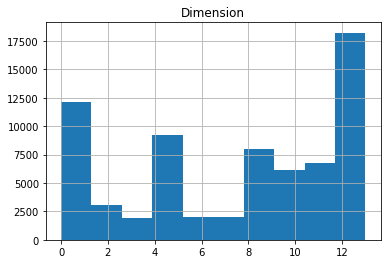

In [2]:
#df = pd.read_csv("../Data/Flujo1.csv", sep=";")
df = pd.read_csv('drive/My Drive/Tesis/Data/Flujo1.csv', sep=";")
df = df[df.Area == 'Social Externo']
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)
list_raw_dimensions = df.Dimension.unique().tolist()
def enumerate_dimensions(dimension):
    return list_raw_dimensions.index(dimension)

df['Dimension'] = df.Dimension.apply(enumerate_dimensions)
model = Word2Vec.load('drive/My Drive/Tesis/modelWord2vec.bin')
list_responses = list(df.Respuesta)
list_dimensions = list(df.Dimension)
df.hist('Dimension')

In [0]:
def make_feature_vec(words, model, num_features):
    feature_vec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec,model[word])
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec
def get_avg_feature_vecs(reviews, model, num_features):
    counter = 0
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1
    return review_feature_vecs

In [4]:
num_features = 10
list_responses_vec = get_avg_feature_vecs(list_responses, model, num_features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
x_train, x_test, y_train, y_test = train_test_split(list_responses_vec, list_dimensions, test_size = 0.2, random_state = 0)

In [6]:
forest = RandomForestClassifier(n_jobs=3, oob_score = True, max_depth=9, n_estimators=1000, bootstrap = True)
acc = cross_val_score(forest, list_responses_vec, list_dimensions, scoring='accuracy', cv=10)
print(acc)

[0.43845269 0.44447641 0.43741007 0.40906475 0.41652274 0.4281394
 0.41618664 0.38020458 0.35835735 0.34510086]


In [7]:
forest.fit(x_train , y_train)
predicctions = forest.predict(x_test)
score = accuracy_score(y_test ,predicctions)
print("Predicting labels for test data..")
print(classification_report(y_test, predicctions))

Predicting labels for test data..
              precision    recall  f1-score   support

           0       0.40      0.24      0.30      1247
           1       0.32      0.21      0.25      1134
           2       0.52      0.06      0.11       645
           3       0.65      0.17      0.27       350
           4       0.42      0.59      0.49       988
           5       0.43      0.42      0.43       836
           6       0.56      0.42      0.48       432
           7       0.50      0.54      0.52       376
           8       0.64      0.46      0.53      1204
           9       0.53      0.20      0.29       403
          10       0.51      0.47      0.49      1257
          11       0.37      0.02      0.03      1341
          12       0.36      0.78      0.50      3292
          13       0.46      0.03      0.05       388

    accuracy                           0.42     13893
   macro avg       0.48      0.33      0.34     13893
weighted avg       0.44      0.42      0.37   

In [18]:
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
classifier = OneVsRestClassifier(RandomForestClassifier(n_jobs=3, oob_score = True, max_depth=9, n_estimators=1000, bootstrap = True))
y_score = classifier.fit(x_train, y_train).decision_function(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(list_raw_dimensions)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

AttributeError: ignored